# N.B.

After this notebook, we will switch back to Julia language.
The reasons are threefold:

* Julia provides a decent performance boost for free;
* Julia is the main language at LakeTide, technical support has neither distance nor latency;
* Julia has better support for OpenStreetMap, which is needed for future traffic simulation.

Switching from Julia to Python was not a bad idea per se;
Python plus Networkx worked quite well in the last two weeks as
the tool set to conduct the proof of concepts; currently, new
needs demand new set of tools.

# Heads-Up

In this notebook, we scale up the graph to 1000 nodes;
this makes the size of samples around one billion, which
makes it impossible to be generated and further augmented.

The way to cope with that is to randomly sample pairs of nodes
and generate training data from them. Idealy, the training size
before augmentation is around one millon.

The meaning of this stocastic manner is twofold.
* it reduced the complexity of training set generation massively
* this is a decent test to see if the model is truly able to generalize

# Problems

The algorithm does not seem to work well with a graph
of 1000 nodes, which is somehow disappointing.

Possible reasons are the following:

* The model is not powerful enough to learn the graph;
* The stochastic sampling of training data does not show the model the big picture, i.e.,
the model gets confused by the edges it has never seen before;

* The training sample should allow the model the take steps back, i.e., for each sample
path, the parent nodes should be included;

However, after deeper analysis, we tend to believe that it is certain properties of 
the graph that make the current model much harder to be trained and to infer. ("./Mar_19/")

# Make it "smarter" TODO

* Detect dead loop;
* <del>Include the parent nodes for training</del> (**tests show that this makes the model harder to be trained and less "intelligent"**)
* Randomize the input vectors during inference
* Add a new heuristic, i.e., for each first order edge, 
look ahead a certain number of steps and use a greedy
strategy to always go with the edge with the largest centrality;
(adding the last node might help, geo-location, cos-distance, Euclidean-distance etc.)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g, load_model

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:09.241393. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [3]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,\
                          weight_max=WEIGHT_MAX,\
                          grid_size=20000):
    
    G = nx.Graph()
    
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:10.003553. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:18.074204. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


4
2
100
174


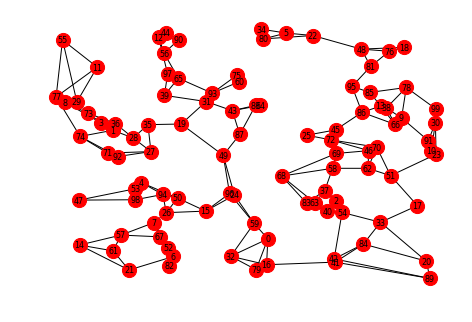

In [5]:
# G = nx.read_gpickle("./Mar_19/graph.pickle")

G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

plot_g(G, with_labels=True, node_size=200, font_size=8)

In [6]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        
#         print(cur_node)
#         print(edge_tuples)
#         print('')
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, num_train_node_pairs=400,\
                                    num_test_node_pairs=100, verbose_frequence=100):
    
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    
    pair_path_dict = dict()
    
    train_selected_pairs = []
    test_selected_pairs = []
    num_of_nodes = G.number_of_nodes()
    
    train_mode = True
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            shortest_path = nx.dijkstra_path(G, src, dst)
                
        except NetworkXNoPath:
#                 print("No path between %d and %d" % (src, dst))
            continue
    
        for path in [shortest_path, shortest_path[::-1]]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
            
            if train_mode and len(train_selected_pairs) < num_train_node_pairs:
                train_selected_pairs.append((src, dst))
            else:
                train_mode = False
                if len(test_selected_pairs) < num_test_node_pairs:
                    test_selected_pairs.append((src, dst))
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#                 print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                if train_mode:
                    train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    train_labels.append(mid_node)
                else:
                    test_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    test_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
#                 sample_cnt += 1
                
#                 if sample_cnt % frequent == 0:
#                     print("Collected %d samples." % (sample_cnt))
        
#         print('len of train_selected_pairs: %d' % len(train_selected_pairs))
#         print('len of test_selected_pairs: %d' % len(test_selected_pairs))
        if len(train_selected_pairs) >= num_train_node_pairs \
            and len(test_selected_pairs) >= num_test_node_pairs:
            break
        
    return train_features, train_labels, test_features, test_labels, train_selected_pairs, test_selected_pairs, pair_path_dict

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:22.476281. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [7]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation=False, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            
            if augmentation:
                np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
#             if cnt % print_freq == 0:
#                 print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:23.321980. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [8]:
def generate_samples_from_graph(num_node_pairs, graph_size=100, augmentation=False, augmentation_index=1, label='Train'):
    
    G = generate_low_degree_g(num_nodes=graph_size)
    
#     plot_g(G, with_labels=True, node_size=200, font_size=8)
    
    features, labels, _, _, selected_pairs, _, pair_path_dict =\
            generate_stochastic_dataset(G, num_train_node_pairs=num_node_pairs, num_test_node_pairs=0)
        
    X, y = augment_dataset(features, labels,\
                           augmentation=augmentation,
                           augmentation_index=augmentation_index, \
                           print_freq=600)
    
    assert len(features) == len(labels)
#     assert len(y) == len(labels)
    assert len(X) == len(y)
    
    print(label)
    print("%d pairs are selected for training" % (len(selected_pairs)))
    print("len of pair_path_dict: %d" % (len(pair_path_dict)))
    print("Num of training sample: %d" % len(y))
    print(label)
    print('\n')
    
    return X, y, G, pair_path_dict

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:24.048279. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [9]:
X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=2000, augmentation=True, augmentation_index=10, label='Train')
X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=200, augmentation=False, label='Validation')

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:27.170079. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Train
2000 pairs are selected for training
len of pair_path_dict: 2000
Num of training sample: 216660
Train


Validation
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 1744
Validation




In [10]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:30.768316. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [63]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=2048)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc1 = mx.sym.Dropout(data=fc1)
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=1024)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    fc2 = mx.sym.Dropout(data=fc2)
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [118]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 200),
#               epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=50) 

# We test the model on node pairs sampled from new graph

In [12]:
model = load_model("mymodel", 10, train_iter, context=mx.cpu())

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:56:57.626113. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [14]:
X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=200, graph_size=200, augmentation=False, augmentation_index=1, label='Test')
pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=128)).asnumpy(), axis=1)
acc = accuracy_score(y_test, pred_test)
print("Accuracy on test set: %f" % (acc))

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-09 23:57:10.635491. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Test
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 3394
Test


Accuracy on test set: 0.928403


In [241]:
graph_sizes = [100, 500, 1000]
stats = [[] for _ in range(len(graph_sizes))]
sample_size_stats = [[] for _ in range(len(graph_sizes))]
number_of_tests = 100
num_node_pairs = 400

In [ ]:
for idx, num_nodes in enumerate(graph_sizes):
    
    print('Working on graphs with %d nodes' % num_nodes)
    for i in range(number_of_tests):
        
        if i > 0 and i % 5 == 0:
            print("Processed %d graphs" % i)
            
        X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=num_nodes, augmentation=False, label='Test')

        pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test)).asnumpy(), axis=1)
        acc = accuracy_score(y_test, pred_test)
        stats[idx].append(acc)
        sample_size_stats[idx].append(len(y_test))

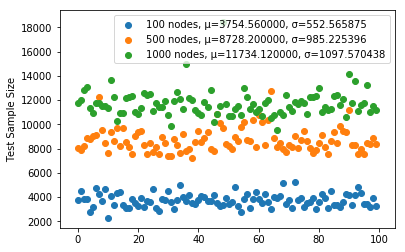

In [243]:
for idx, stat in enumerate(sample_size_stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Test Sample Size")
plt.legend(loc='best')
plt.show()

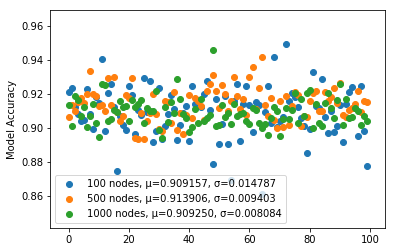

In [244]:
for idx, stat in enumerate(stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Model Accuracy")
plt.legend(loc='best')
plt.show()

# We evaluate the paths generated by the model

In [26]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model, real_time_weight=False):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    assert max_degree == 4
    real_time_weight_change_factors = np.array([random.expovariate(lambd=1.0)\
                                                for _ in range(max_degree)])\
                                if real_time_weight else np.ones(max_degree)
    
    # change the weights of all edges
    input_vec[:, 1] = np.multiply(input_vec[:, 1], real_time_weight_change_factors)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        #print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
            
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, p=0.0, model=None,\
                         invalid_path_threshold=G.number_of_nodes(),
                         real_time_weight=False):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        neigbors = list(G.neighbors(cur_node))
        num_neighbors = len(neigbors)
        
        pred_next_node, _ = nn_infer_next_node(G, path, parent_node,\
                                               cur_node, src, dst, model,\
                                               real_time_weight=real_time_weight)
        pred_next_idx = neigbors.index(pred_next_node)
        
        sample_probabilities = [p/(num_neighbors-1)\
                                for _ in range(num_neighbors)]
        sample_probabilities[pred_next_idx] = 1-p
        assert sum(sample_probabilities) <= 1.0
        
        next_node = np.random.choice(neigbors, 1, p=sample_probabilities)[0]
        total_weights += G.get_edge_data(cur_node, next_node)['weight']
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 00:13:39.149371. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [27]:
def calc_path_weight_sum(G, path):
    
    weight_sum = 0.0
    
    for idx, node in enumerate(path[:-1]):
        weight_sum += G.edges[(node, path[idx + 1])]['weight']
        
    return weight_sum

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 00:13:40.242091. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [39]:
def calc_statistics(G, pair_path_dict, num_to_test=100, verbose=True):
    found_cnt = 0
    opt_path_cnt = 0
    edge_efficiency = {}
    time_efficiency = {}
    
    pairs = pair_path_dict.keys()
    random.shuffle(pairs)
    
    for src, dst in pairs[:num_to_test]:

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(src, dst)]
        
        if not found:
            
#             print("The model is unable to find a path between %d and %d" % (src, dst))
            
#             plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            
#             print("Dijkstra path :", dijkstra_path)
# #             print("NN path :", nn_path)
#             print('')
            continue

        found_cnt += 1
        
        edge_efficiency[(src, dst)] = float(len(dijkstra_path)-1) / (len(nn_path)-1)
        time_efficiency[(src, dst)] = calc_path_weight_sum(G, dijkstra_path) \
                                        / calc_path_weight_sum(G, nn_path)
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1

        else:
            if verbose:
                print("The model is able to find a different path between %d and %d" % (src, dst))
                plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
                print("Dijkstra path :", dijkstra_path)
                print("NN path :", nn_path)
                print('')

    return found_cnt, opt_path_cnt, edge_efficiency, time_efficiency

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 00:17:45.072065. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [42]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100, verbose=True):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt, edge_efficiency, time_efficiency = calc_statistics(G,\
                                                                pair_path_dict=pair_path_dict,\
                                                                num_to_test=num_to_test,
                                                                verbose=verbose)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))
    
    edge_efficiency_values = edge_efficiency.values()
    stat_mean = np.mean(edge_efficiency_values)
    stat_std = np.std(edge_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(edge_efficiency), stat_mean, stat_std)
    print(label)
    
    time_efficiency_values = time_efficiency.values()
    stat_mean = np.mean(time_efficiency_values)
    stat_std = np.std(time_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(time_efficiency), stat_mean, stat_std)
    print(label)

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 00:18:34.904253. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [31]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    
    plt.legend(loc='best')
    plt.show()

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 00:14:02.189412. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 00:19:06.816059. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Test
100 pairs are selected for training
len of pair_path_dict: 100
Num of training sample: 982
Test


The model is able to find a different path between 89 and 18


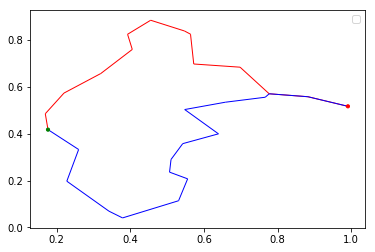

('Dijkstra path :', [89, 26, 38, 71, 72, 8, 10, 23, 5, 36, 15, 83, 0, 18])
('NN path :', [89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 55, 18])

The model is able to find a different path between 18 and 89


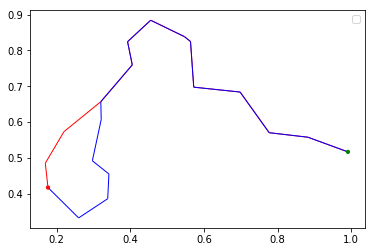

('Dijkstra path :', [18, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 26, 89])
('NN path :', [18, 55, 12, 7, 41, 49, 15, 36, 5, 23, 10, 8, 72, 71, 38, 26, 89])

The model is able to find a different path between 43 and 13


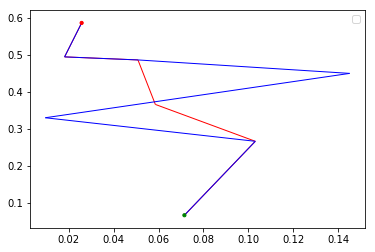

('Dijkstra path :', [43, 33, 97, 21, 50, 13])
('NN path :', [43, 33, 97, 88, 77, 50, 13])

The model is able to find a different path between 41 and 87


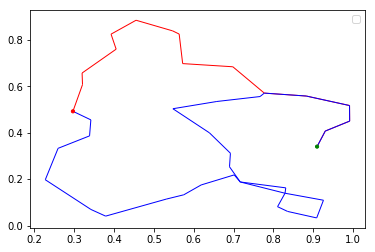

('Dijkstra path :', [41, 49, 15, 36, 5, 23, 10, 8, 72, 71, 38, 26, 89, 86, 98, 87])
('NN path :', [41, 7, 12, 55, 81, 59, 52, 69, 68, 84, 67, 92, 37, 94, 16, 46, 78, 37, 90, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98, 87])

The model is able to find a different path between 80 and 45


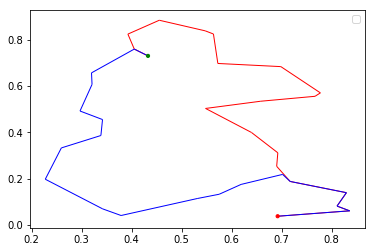

('Dijkstra path :', [80, 16, 94, 37, 92, 70, 85, 40, 51, 11, 1, 38, 71, 72, 8, 10, 23, 5, 36, 45])
('NN path :', [80, 16, 94, 37, 92, 67, 84, 68, 69, 52, 59, 81, 55, 12, 7, 41, 49, 15, 36, 45])

The model is able to find a different path between 18 and 3


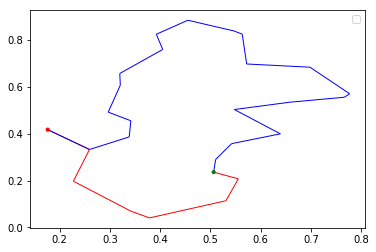

('Dijkstra path :', [18, 55, 81, 59, 52, 69, 63, 3])
('NN path :', [18, 55, 12, 7, 41, 49, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 19, 56, 3])

The model is able to find a different path between 20 and 35


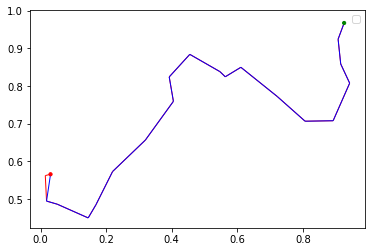

('Dijkstra path :', [20, 58, 33, 97, 88, 0, 83, 15, 36, 5, 23, 10, 8, 34, 30, 17, 74, 64, 9, 22, 35])
('NN path :', [20, 33, 97, 88, 0, 83, 15, 36, 5, 23, 10, 8, 34, 30, 17, 74, 64, 9, 22, 35])

The model is able to find a different path between 99 and 8


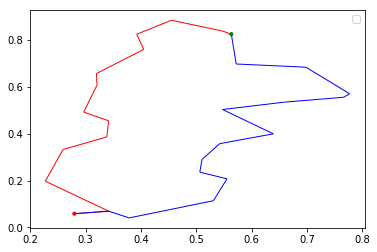

('Dijkstra path :', [99, 59, 81, 55, 12, 7, 41, 49, 15, 36, 5, 23, 10, 8])
('NN path :', [99, 59, 52, 69, 63, 3, 56, 19, 40, 51, 11, 1, 38, 71, 72, 8])

The model is able to find a different path between 62 and 84


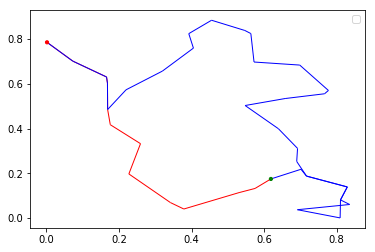

('Dijkstra path :', [62, 54, 44, 31, 0, 18, 55, 81, 59, 52, 69, 68, 84])
('NN path :', [62, 54, 44, 31, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84])

The model is able to find a different path between 83 and 69


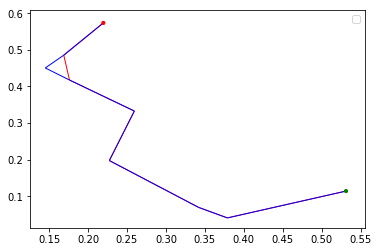

('Dijkstra path :', [83, 0, 18, 55, 81, 59, 52, 69])
('NN path :', [83, 0, 88, 18, 55, 81, 59, 52, 69])

The model is able to find a different path between 93 and 49


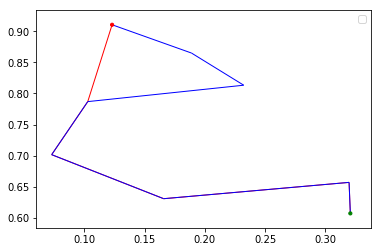

('Dijkstra path :', [93, 61, 54, 44, 15, 49])
('NN path :', [93, 57, 53, 61, 54, 44, 15, 49])

The model is able to find a different path between 26 and 18


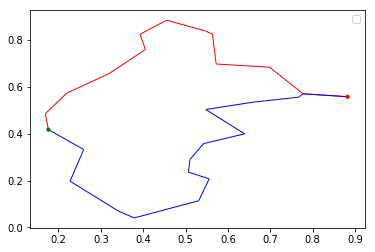

('Dijkstra path :', [26, 38, 71, 72, 8, 10, 23, 5, 36, 15, 83, 0, 18])
('NN path :', [26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 55, 18])

The model is able to find a different path between 95 and 6


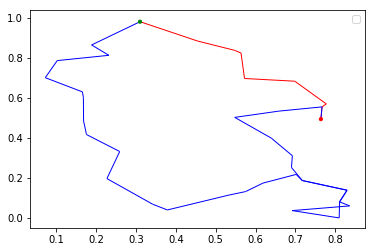

('Dijkstra path :', [95, 1, 38, 71, 72, 8, 10, 23, 6])
('NN path :', [95, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84, 68, 69, 52, 59, 81, 55, 18, 0, 31, 44, 54, 61, 53, 57, 6])

The model is able to find a different path between 34 and 60


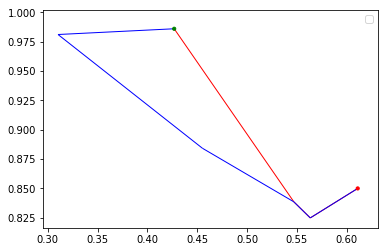

('Dijkstra path :', [34, 8, 10, 60])
('NN path :', [34, 8, 10, 23, 6, 60])

The model is able to find a different path between 20 and 52


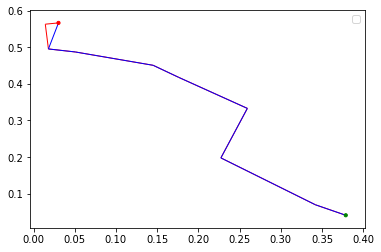

('Dijkstra path :', [20, 58, 33, 97, 88, 18, 55, 81, 59, 52])
('NN path :', [20, 33, 97, 88, 18, 55, 81, 59, 52])

The model is able to find a different path between 60 and 3


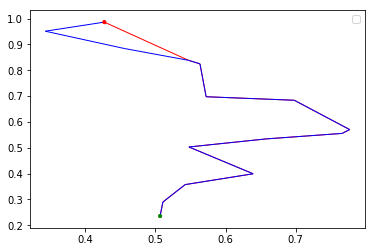

('Dijkstra path :', [60, 10, 8, 72, 71, 38, 1, 11, 51, 40, 19, 56, 3])
('NN path :', [60, 32, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 19, 56, 3])

The model is able to find a different path between 18 and 26


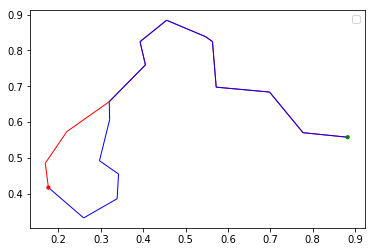

('Dijkstra path :', [18, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 26])
('NN path :', [18, 55, 12, 7, 41, 49, 15, 36, 5, 23, 10, 8, 72, 71, 38, 26])

The model is able to find a different path between 65 and 13


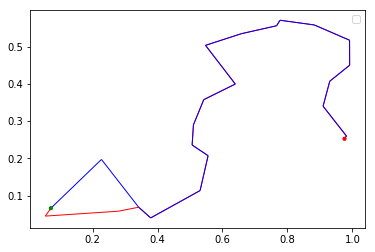

('Dijkstra path :', [65, 28, 87, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 99, 29, 13])
('NN path :', [65, 28, 87, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 13])

The model is able to find a different path between 6 and 59


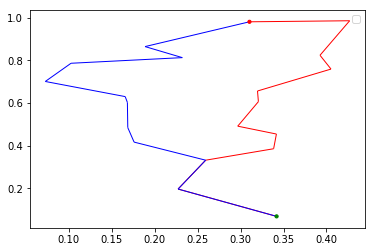

('Dijkstra path :', [6, 60, 5, 36, 15, 49, 41, 7, 12, 55, 81, 59])
('NN path :', [6, 57, 53, 61, 54, 44, 31, 0, 18, 55, 81, 59])

The model is able to find a different path between 37 and 87


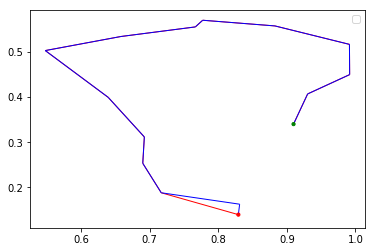

('Dijkstra path :', [37, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98, 87])
('NN path :', [37, 90, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98, 87])

The model is able to find a different path between 98 and 43


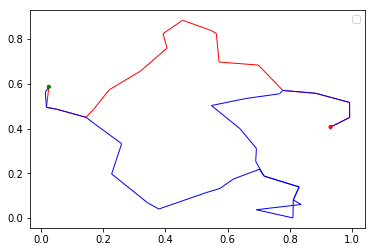

('Dijkstra path :', [98, 86, 89, 26, 38, 71, 72, 8, 10, 23, 5, 36, 15, 83, 0, 88, 97, 33, 43])
('NN path :', [98, 86, 89, 26, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84, 68, 69, 52, 59, 81, 55, 18, 88, 97, 33, 58, 43])

The model is able to find a different path between 3 and 18


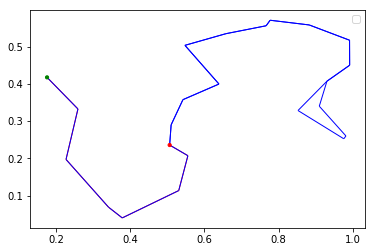

('Dijkstra path :', [3, 63, 69, 52, 59, 81, 55, 18])
('NN path :', [3, 56, 19, 40, 51, 11, 1, 38, 26, 89, 86, 98, 76, 65, 28, 87, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 55, 18])

The model is able to find a different path between 59 and 6


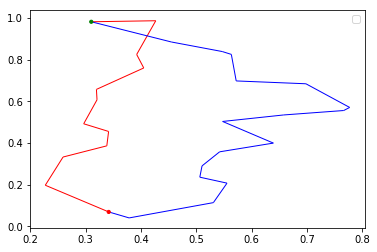

('Dijkstra path :', [59, 81, 55, 12, 7, 41, 49, 15, 36, 5, 60, 6])
('NN path :', [59, 52, 69, 63, 3, 56, 19, 40, 51, 11, 1, 38, 71, 72, 8, 10, 23, 6])

The model is able to find a different path between 33 and 67


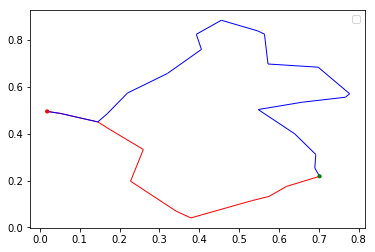

('Dijkstra path :', [33, 97, 88, 18, 55, 81, 59, 52, 69, 68, 84, 67])
('NN path :', [33, 97, 88, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 67])

The model is able to find a different path between 35 and 87


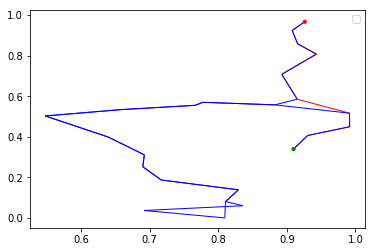

('Dijkstra path :', [35, 22, 9, 64, 74, 91, 89, 86, 98, 87])
('NN path :', [35, 22, 9, 64, 74, 91, 26, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98, 87])

The model is able to find a different path between 73 and 99


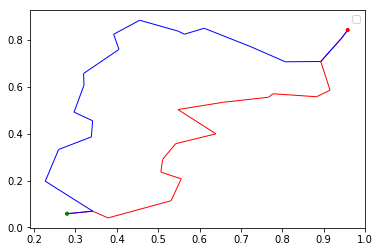

('Dijkstra path :', [73, 64, 74, 91, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 99])
('NN path :', [73, 64, 74, 17, 30, 34, 8, 10, 23, 5, 36, 15, 49, 41, 7, 12, 55, 81, 59, 99])

The model is able to find a different path between 84 and 62


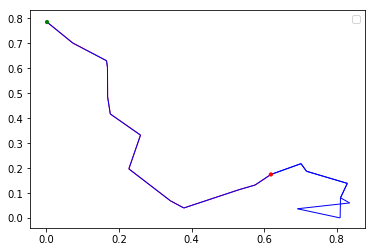

('Dijkstra path :', [84, 68, 69, 52, 59, 81, 55, 18, 0, 31, 44, 54, 62])
('NN path :', [84, 67, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84, 68, 69, 52, 59, 81, 55, 18, 0, 31, 44, 54, 62])

The model is able to find a different path between 96 and 98


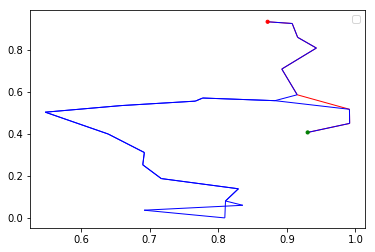

('Dijkstra path :', [96, 22, 9, 64, 74, 91, 89, 86, 98])
('NN path :', [96, 22, 9, 64, 74, 91, 26, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98])

The model is able to find a different path between 98 and 93


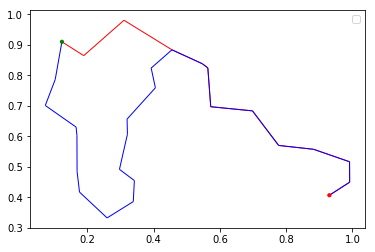

('Dijkstra path :', [98, 86, 89, 26, 38, 71, 72, 8, 10, 23, 6, 57, 93])
('NN path :', [98, 86, 89, 26, 38, 71, 72, 8, 10, 23, 5, 36, 15, 49, 41, 7, 12, 55, 18, 0, 31, 44, 54, 61, 93])

The model is able to find a different path between 87 and 41


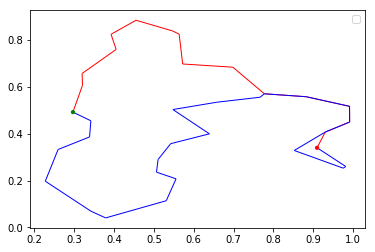

('Dijkstra path :', [87, 98, 86, 89, 26, 38, 71, 72, 8, 10, 23, 5, 36, 15, 49, 41])
('NN path :', [87, 28, 65, 76, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 55, 12, 7, 41])

The model is able to find a different path between 93 and 98


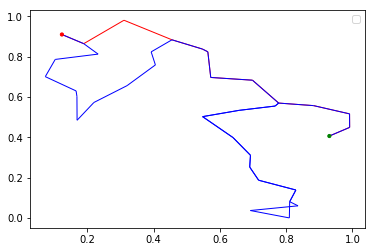

('Dijkstra path :', [93, 57, 6, 23, 10, 8, 72, 71, 38, 26, 89, 86, 98])
('NN path :', [93, 57, 53, 61, 54, 44, 31, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98])

The model is able to find a different path between 43 and 98


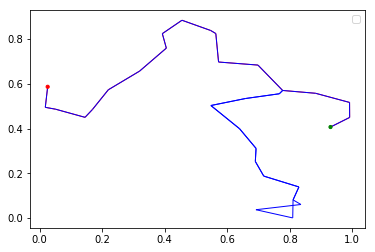

('Dijkstra path :', [43, 33, 97, 88, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 26, 89, 86, 98])
('NN path :', [43, 33, 97, 88, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 70, 85, 40, 51, 11, 1, 38, 26, 89, 86, 98])

The model is able to find a different path between 6 and 92


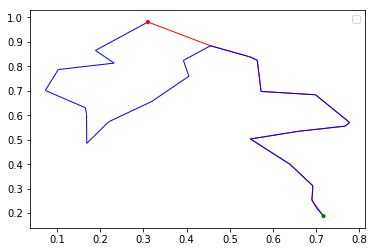

('Dijkstra path :', [6, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 92])
('NN path :', [6, 57, 53, 61, 54, 44, 31, 0, 83, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 67, 92])

The model is able to find a different path between 81 and 90


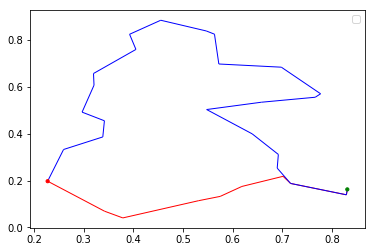

('Dijkstra path :', [81, 59, 52, 69, 68, 84, 67, 92, 37, 90])
('NN path :', [81, 55, 12, 7, 41, 49, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 92, 37, 90])

The model is able to find a different path between 99 and 81


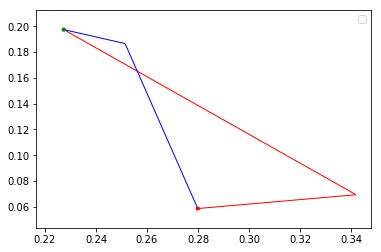

('Dijkstra path :', [99, 59, 81])
('NN path :', [99, 27, 81])

The model is able to find a different path between 49 and 93


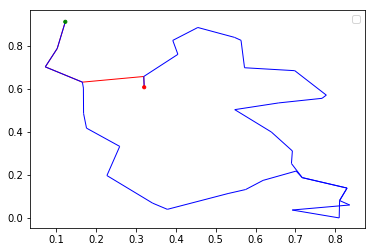

('Dijkstra path :', [49, 15, 44, 54, 61, 93])
('NN path :', [49, 15, 36, 5, 23, 10, 8, 72, 71, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84, 68, 69, 52, 59, 81, 55, 18, 0, 31, 44, 54, 61, 93])

The model is able to find a different path between 91 and 15


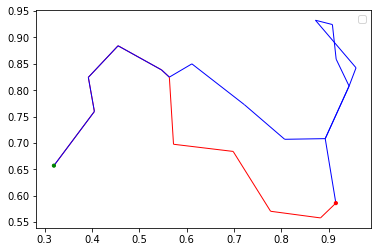

('Dijkstra path :', [91, 26, 38, 71, 72, 8, 10, 23, 5, 36, 15])
('NN path :', [91, 74, 64, 9, 22, 96, 73, 64, 74, 17, 30, 34, 8, 10, 23, 5, 36, 15])

The model is able to find a different path between 95 and 59


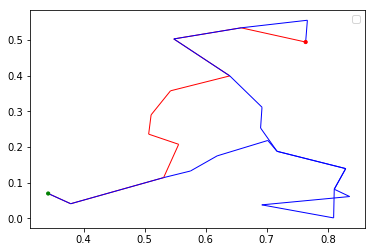

('Dijkstra path :', [95, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59])
('NN path :', [95, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84, 68, 69, 52, 59])

The model is able to find a different path between 3 and 60


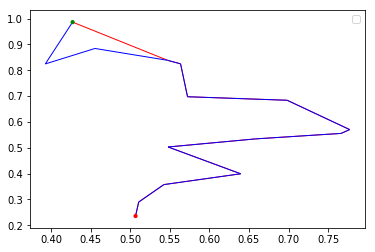

('Dijkstra path :', [3, 56, 19, 40, 51, 11, 1, 38, 71, 72, 8, 10, 60])
('NN path :', [3, 56, 19, 40, 51, 11, 1, 38, 71, 72, 8, 10, 23, 5, 60])

The model is able to find a different path between 28 and 13


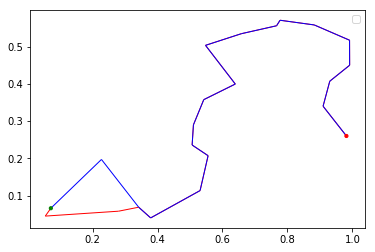

('Dijkstra path :', [28, 87, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 99, 29, 13])
('NN path :', [28, 87, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 13])

The model is able to find a different path between 96 and 52


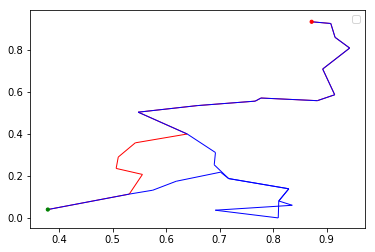

('Dijkstra path :', [96, 22, 9, 64, 74, 91, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52])
('NN path :', [96, 22, 9, 64, 74, 91, 26, 38, 1, 11, 51, 40, 85, 70, 92, 37, 94, 16, 80, 4, 94, 37, 92, 67, 84, 68, 69, 52])

The model is able to find a different path between 56 and 7


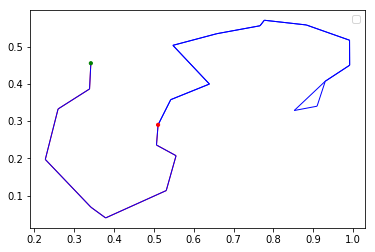

('Dijkstra path :', [56, 3, 63, 69, 52, 59, 81, 55, 12, 7])
('NN path :', [56, 19, 40, 51, 11, 1, 38, 26, 89, 86, 98, 87, 76, 98, 86, 89, 26, 38, 1, 11, 51, 40, 19, 56, 3, 63, 69, 52, 59, 81, 55, 12, 7])

The model is able to find a different path between 37 and 71


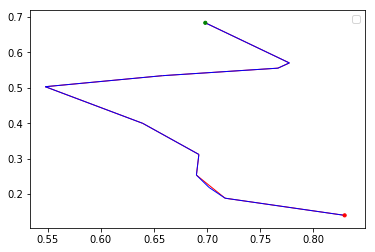

('Dijkstra path :', [37, 92, 70, 85, 40, 51, 11, 1, 38, 71])
('NN path :', [37, 92, 67, 70, 85, 40, 51, 11, 1, 38, 71])

85 out of 100 can find path: 0.850000
42 out of 85 can find optimal path: 0.494118
42 out of 100 all paths can find optimal paths: 0.420000
85 pairs, μ=0.824834, σ=0.260883
85 pairs, μ=0.833899, σ=0.249875


In [45]:
num_node_pairs = 100

_, _, G_test, pair_path_dict = generate_samples_from_graph(num_node_pairs=num_node_pairs,\
                                                           graph_size=100,\
                                                           augmentation=False,\
                                                           label='Test')

print_paths_statistics(G_test,\
                       num_to_test=num_node_pairs,\
                       pair_path_dict=pair_path_dict,
                       verbose=True)

# Some Analysis

It seems that in the cases where the model fails to find a path, the model is trapped in a dead loop; however, at the early stage of inference, the generated path is not absolute
nonsense. At some point, the model makes a dubious turn and the paths are likely to diverge.

The model has learned, to some extent, to crawl its way back to where it made a mistake and
make it to the destination; 

this is understandable since the training set sampling is bidirectional; 
more specifically, whenever a pair of nodes are selected, the paths from 
both directions are calculated and recorded; this provides the model with
the information about how to get back when the current path chosen is too
wrong.

# Shortest Path Strategy + Exploration

We investigate how the paths are affected by the added exploration
strategy. Stated differently, an agene is both exploiting with learned shortest path strategy and exploring random nodes by probability $p$. This means the agent will follow it prediction
with probability $1-p$.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 01:00:59.440537. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


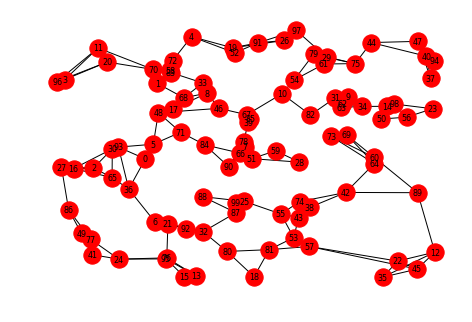

In [61]:
G = generate_low_degree_g()
plot_g(G)

In [62]:
def sample_node_pairs(num_node_pairs, num_of_nodes):
    
    pair_path_dict = dict()
    
    while True:
        
        if len(pair_path_dict) >= num_node_pairs:
            break
        
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst or (src, dst) in pair_path_dict or not nx.has_path(G, src, dst):
            continue
            
        pair_path_dict[(src, dst)] = []
        pair_path_dict[(dst, src)] = []
        
    return pair_path_dict

pair_path_dict = sample_node_pairs(200, G.number_of_nodes())

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 01:01:03.934695. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [63]:
p_group = [0.0]

arrival_rate = [[] for _ in range(len(p_group))]
edge_efficiency_groups = [[] for _ in range(len(p_group))]
time_efficiency_groups = [[] for _ in range(len(p_group))]

model = load_model("mymodel", 10, train_iter, context=mx.cpu())

for idx_p_group, p in enumerate(p_group):
    
    print("Working on %f group" % p)
    
    for i in range(50):
        
        if i > 0 and i % 5 == 0:
            print("Repeated %d times" % i)
            
        cnt = 0
        edge_efficiency = []
        time_efficiency = []
        
        for idx, pair in enumerate(pair_path_dict):
                
            src, dst = pair[0], pair[1]
            path, total_weight, found = dijkstra_path_finder(G, src, dst,\
                                                             p=p, model=model,\
                                                             real_time_weight=True)

            if not found:
                continue
                
            cnt += 1
            assert total_weight == calc_path_weight_sum(G, path)
            dijkstra_path = nx.dijkstra_path(G, src, dst)
            
            edge_efficiency.append(float(len(dijkstra_path)-1) / (len(path)-1))
            time_efficiency.append(calc_path_weight_sum(G, dijkstra_path) \
                                        / total_weight)

        arrival_rate[idx_p_group].append(float(cnt)/len(pair_path_dict))
        
        edge_efficiency_groups[idx_p_group].append(edge_efficiency)
        
        time_efficiency_groups[idx_p_group].append(time_efficiency)
        

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 01:01:06.964265. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Working on 0.000000 group
Repeated 5 times
Repeated 10 times
Repeated 15 times
Repeated 20 times
Repeated 25 times
Repeated 30 times
Repeated 35 times
Repeated 40 times
Repeated 45 times


In [ ]:
colors = ['r', 'g', 'b', 'k']

for idx, rate in enumerate(arrival_rate):
    stat_mean = np.mean(rate)
    stat_std = np.std(rate)
    label = u'%0.2f exploration, $\mu$=%0.4f, $\sigma$=%0.4f' % \
            (p_group[idx], stat_mean, stat_std)
    
    plt.scatter(list(range(50)), rate, label=label, c=colors[idx])

plt.ylabel("Arrival Rate")
plt.xlabel("Test Run")
plt.legend(loc='lower right')
plt.show()

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 01:10:47.881104. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


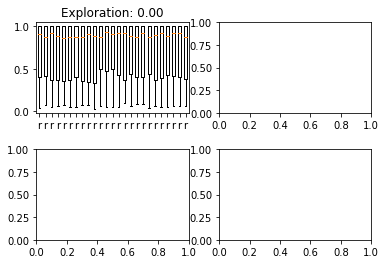

In [68]:

f, axarr = plt.subplots(2, 2)

for i in range(1):
    random.shuffle(time_efficiency_groups[i])
    axarr[int(i/2), i%2].boxplot(time_efficiency_groups[i][:25], labels=['r'] * 25)
    axarr[int(i/2), i%2].set_title("Exploration: %0.2f"% p_group[i])

f.subplots_adjust(hspace=0.4)
plt.show()


# Real Time Routing Experiment

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 11:01:21.241466. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


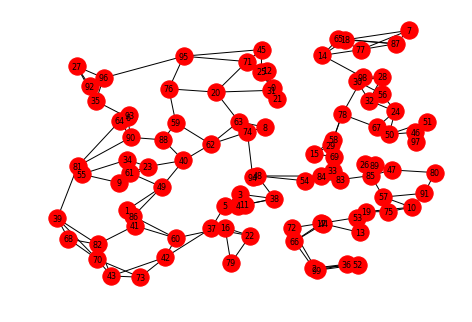

In [98]:
G = generate_low_degree_g()
plot_g(G)

In [99]:
pair_path_dict = sample_node_pairs(200, G.number_of_nodes())

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 11:01:25.163051. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [100]:
arrival_rate = []
real_time_arrival_rate = []

edge_efficiency = []
time_efficiency = []

real_time_edge_efficiency = []
real_time_time_efficiency = []

model = load_model("mymodel", 10, train_iter, context=mx.cpu())
    
for i in range(50):

    if i > 0 and i % 5 == 0:
        print("Repeated %d times" % i)

    cnt = 0
    real_time_cnt = 0
    edge_efficiency_tmp = []
    time_efficiency_tmp = []
    
    real_time_edge_efficiency_tmp = []
    real_time_time_efficiency_tmp = []

    for idx, pair in enumerate(pair_path_dict):

        src, dst = pair[0], pair[1]
        path, total_weight, found = dijkstra_path_finder(G, src, dst,\
                                                         p=p, model=model,\
                                                         real_time_weight=False)
        
        dijkstra_path = nx.dijkstra_path(G, src, dst)
        
        if found:
            cnt += 1
            assert total_weight == calc_path_weight_sum(G, path)

            edge_efficiency_tmp.append(float(len(dijkstra_path)-1) / (len(path)-1))
            time_efficiency_tmp.append(calc_path_weight_sum(G, dijkstra_path) \
                                        / total_weight)
            
        path, total_weight, found = dijkstra_path_finder(G, src, dst,\
                                                         p=p, model=model,\
                                                         real_time_weight=True)
        
        if found:
            real_time_cnt += 1
            assert total_weight == calc_path_weight_sum(G, path)
            
            real_time_edge_efficiency_tmp.append(float(len(dijkstra_path)-1) / (len(path)-1))
            real_time_time_efficiency_tmp.append(calc_path_weight_sum(G, dijkstra_path) \
                                        / total_weight)
            
    arrival_rate.append(float(cnt)/len(pair_path_dict))
    real_time_arrival_rate.append(float(real_time_cnt)/len(pair_path_dict))
    
    edge_efficiency.append(edge_efficiency_tmp)
    real_time_edge_efficiency.append(real_time_edge_efficiency_tmp)
    
    time_efficiency.append(time_efficiency_tmp)
    real_time_time_efficiency.append(real_time_time_efficiency_tmp)
        

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 11:01:32.436851. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Repeated 5 times
Repeated 10 times
Repeated 15 times
Repeated 20 times
Repeated 25 times
Repeated 30 times
Repeated 35 times
Repeated 40 times
Repeated 45 times


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 11:13:57.137992. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


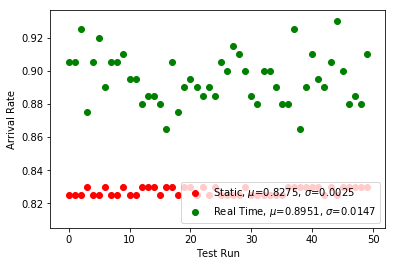

In [101]:
colors = ['r', 'g', 'b', 'k']
labels = ['Static', 'Real Time']
for idx, rate in enumerate([arrival_rate, real_time_arrival_rate]):
    stat_mean = np.mean(rate)
    stat_std = np.std(rate)
    label = u'%s, $\mu$=%0.4f, $\sigma$=%0.4f' % \
            (labels[idx], stat_mean, stat_std)
    
    plt.scatter(list(range(50)), rate, label=label, c=colors[idx])

plt.ylabel("Arrival Rate")
plt.xlabel("Test Run")
plt.legend(loc='lower right')
plt.show()

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-06-10 11:30:34.533048. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


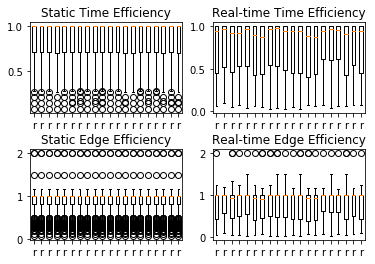

In [108]:

f, axarr = plt.subplots(2, 2)
first_cnt = 20

axarr[0, 0].boxplot(time_efficiency[:first_cnt], labels=['r'] * first_cnt)
axarr[0, 0].set_title('Static Time Efficiency')

axarr[0, 1].boxplot(real_time_time_efficiency[:first_cnt], labels=['r'] * first_cnt)
axarr[0, 1].set_title('Real-time Time Efficiency')

axarr[1, 0].boxplot(edge_efficiency[:first_cnt], labels=['r'] * first_cnt)
axarr[1, 0].set_title('Static Edge Efficiency')

axarr[1, 1].boxplot(real_time_edge_efficiency[:first_cnt], labels=['r'] * first_cnt)
axarr[1, 1].set_title('Real-time Edge Efficiency')

f.subplots_adjust(hspace=0.4)
plt.show()